# 第1回目の着順予想
- 21/03/14に作成開始

## データ準備
- 枠番ごとに行を作成
- 統計量は何も入れない
### target 
- 1枠については、1着の場合1, 2着以降の場合は0に二値化
- ２枠以降については、3着以内であれば1、そうでなければ0に二値化
- これらをまとめて一つの行列にした上でモデルを作成

# 予測モデル
- Logistic regression, Random Forest, light BGMの三つを用いて予想を行い、それぞれの性能を評価。

In [1]:
import pandas as pd

## データ準備
### データロード

In [2]:
race_df = pd.read_pickle('./arrangedData/data_formatted_1.pkl').reset_index(drop=True)

# 中身を確認
race_df.loc[6:18, :]

,date,venue,raceNumber,枠,num_false_start,num_late_start,racer_class,ボート2連率,ボート3連率,モーター2連率,...,temperature,tilt,water_temperature,wave_height,weight,wind_speed,着順,weather_曇り,weather_雨,weather_雪
6,2021-02-01,津,2.0,1,0,0,3,17.95,35.90,30.93,...,6.0,-0.5,6.0,1,55.1,1,2,1,0,0
7,2021-02-01,津,2.0,2,0,0,4,24.68,42.86,24.51,...,6.0,-0.5,6.0,1,52.1,1,3,1,0,0
8,2021-02-01,津,2.0,3,0,0,3,29.11,54.43,24.72,...,6.0,-0.5,6.0,1,55.4,1,1,1,0,0
9,2021-02-01,津,2.0,4,0,0,3,36.96,54.35,40.66,...,6.0,-0.5,6.0,1,52.2,1,6,1,0,0
10,2021-02-01,津,2.0,5,0,0,3,33.33,50.57,27.38,...,6.0,-0.5,6.0,1,53.9,1,5,1,0,0
11,2021-02-01,津,2.0,6,0,0,4,31.82,50.00,29.17,...,6.0,-0.5,6.0,1,52.0,1,4,1,0,0
12,2021-02-01,津,3.0,1,0,0,3,34.44,45.56,28.04,...,6.0,-0.5,6.0,1,52.4,2,1,1,0,0
13,2021-02-01,津,3.0,2,0,0,1,24.00,42.67,25.00,...,6.0,-0.5,6.0,1,53.7,2,2,1,0,0
14,2021-02-01,津,3.0,3,1,0,2,37.18,50.00,32.00,...,6.0,-0.5,6.0,1,52.0,2,3,1,0,0
15,2021-02-01,津,3.0,4,1,0,2,35.63,49.43,23.71,...,6.0,-0.5,6.0,1,51.0,2,5,1,0,0


### rank列を作成し、inputにできない列を削除
- 1枠は1着ならば1, そうでなければ0
- 2枠以降については、3着以内なら1, そうでなければ0
- inputにできない列を削除

In [3]:
# 1枠は1着ならば1, そうでなければ0
race_df.loc[(race_df["枠"]==1) & (race_df["着順"]==1), "rank"] = 1
race_df.loc[(race_df["枠"]==1) & (race_df["着順"]!=1), "rank"] = 0

# 2枠以降については、3着以内なら1, そうでなければ0
race_df.loc[(race_df["枠"]!=1) & (race_df["着順"]<4), "rank"] = 1
race_df.loc[(race_df["枠"]!=1) & (race_df["着順"]>=4), "rank"] = 0

# inputにできない列を削除
race_df.drop(["着順", "date", "venue", "raceNumber"], axis=1, inplace=True)

race_df.head()

,枠,num_false_start,num_late_start,racer_class,ボート2連率,ボート3連率,モーター2連率,モーター3連率,exhibitionTime,exhibition_ST,...,temperature,tilt,water_temperature,wave_height,weight,wind_speed,weather_曇り,weather_雨,weather_雪,rank
0,1,0,0,1,38.46,55.77,36.59,57.32,6.66,0.05,...,8.0,-0.5,6.0,1,52.2,1,1,0,0,1.0
1,2,0,0,3,41.25,60.00,27.93,38.74,6.76,0.20,...,8.0,-0.5,6.0,1,53.1,1,1,0,0,1.0
2,3,0,0,3,25.56,55.56,33.33,53.13,6.79,0.08,...,8.0,-0.5,6.0,1,53.2,1,1,0,0,1.0
3,4,0,0,3,24.66,45.21,37.36,54.95,6.76,0.01,...,8.0,-0.5,6.0,1,52.7,1,1,0,0,0.0
4,5,0,0,4,40.58,57.97,37.39,52.17,6.80,0.04,...,8.0,-0.5,6.0,1,52.9,1,1,0,0,0.0


### training dataとtest dataに分ける

In [4]:
from sklearn.model_selection import train_test_split

X = race_df.drop("rank", axis=1)
y = race_df["rank"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

## Logistic回帰

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression() # ロジスティック回帰モデルのインスタンスを作成
model_lr.fit(X_train, y_train) # ロジスティック回帰モデルの重みを学習

/Users/grice/opt/anaconda3/envs/boatrace2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 性能評価

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred_lr = model_lr.predict(X_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_lr))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred_lr))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred_lr))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred_lr))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred_lr))

confusion matrix = 
 [[3704 1372]
 [2122 2128]]
accuracy =  0.6253484880977911
precision =  0.608
recall =  0.5007058823529412
f1 score =  0.5491612903225807


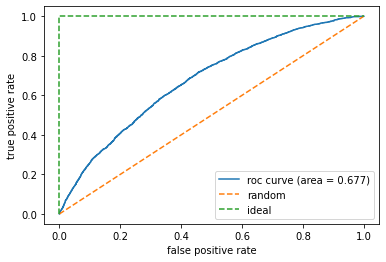

In [7]:
%matplotlib inline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score_lr = model_lr.predict_proba(X_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_lr)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

### 回帰係数を表示

In [8]:
pd.Series(model_lr.coef_[0], index=X_train.columns).sort_values()

racer_class         -0.440407
num_false_start     -0.254384
枠                   -0.163764
exhibition_cource   -0.103785
wind_speed          -0.029107
weather_曇り          -0.025680
weather_雨           -0.025598
exhibition_ST       -0.018693
tilt                -0.011003
num_late_start      -0.008605
temperature         -0.004423
weather_雪           -0.002012
ボート3連率              -0.001554
late                 0.000000
モーター2連率              0.001566
ボート2連率               0.003254
モーター3連率              0.007096
water_temperature    0.010308
weight               0.011261
wave_height          0.025177
flying               0.026922
exhibitionTime       0.103269
dtype: float64

## RandomForest Classification

In [9]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=100)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=100)

### 性能評価

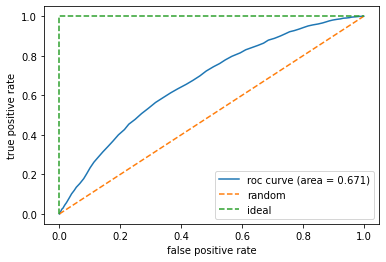

In [10]:
y_score_rf = model_rf.predict_proba(X_test)[:, 1] # 検証データがクラス1に属する確率
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_rf)

plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [11]:
# 過学習の確認用
from sklearn.metrics import roc_auc_score

print('auc = ', roc_auc_score(y_true=y_train, y_score=model_rf.predict_proba(X_train)[:, 1] ))

auc =  1.0


### パラメータ調整

In [12]:
rf_params = {
    "min_samples_split": 300,
    "max_depth": None,
    "random_state": 100
}
# "n_estimators": 60
# "criterion": "entropy",
# "class_weight": "balanced",

model_rf = RandomForestClassifier(**rf_params)
model_rf.fit(X_train, y_train)

print('auc_train = ', roc_auc_score(y_true=y_train, y_score=model_rf.predict_proba(X_train)[:, 1]))
print('auc_test = ', roc_auc_score(y_true=y_test, y_score=model_rf.predict_proba(X_test)[:, 1]))

auc_train =  0.727076211016427
auc_test =  0.6877937236360265


### 回帰係数的な

In [13]:
pd.DataFrame({"features": X_train.columns, "importance": model_rf.feature_importances_}).sort_values("importance", ascending=False)

,features,importance
10,exhibition_cource,0.214368
0,枠,0.212864
3,racer_class,0.205966
7,モーター3連率,0.043697
8,exhibitionTime,0.043595
6,モーター2連率,0.042771
17,weight,0.039010
4,ボート2連率,0.037541
5,ボート3連率,0.036111
9,exhibition_ST,0.025813


## 勾配ブースティング木

In [14]:
import lightgbm as lgb

params = {"num_leaves": 2,
          "n_estimators": 100,
          "class_weight": "balanced",
          "random_state": 100
         }
# "min_data_in_leaf": 

model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train, y_train)

print('auc_train = ', roc_auc_score(y_true=y_train, y_score=model_lgb.predict_proba(X_train)[:, 1]))
print('auc_test = ', roc_auc_score(y_true=y_test, y_score=model_lgb.predict_proba(X_test)[:, 1]))

auc_train =  0.6788519329127702
auc_test =  0.6874709822463264


In [18]:
pd.DataFrame({"features": X_train.columns, "importance": model_lgb.feature_importances_}).sort_values("importance", ascending=False)

,features,importance
3,racer_class,32
0,枠,21
10,exhibition_cource,12
8,exhibitionTime,9
1,num_false_start,9
7,モーター3連率,6
6,モーター2連率,5
17,weight,5
9,exhibition_ST,1
15,water_temperature,0


# 1枠だけのdfを作ってregression

In [21]:
race_df_1 = race_df[race_df["枠"] == 1]

X = race_df_1.drop("rank", axis=1)
y = race_df_1["rank"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

In [22]:
params = {"num_leaves": 2,
          "n_estimators": 100,
          "class_weight": "balanced",
          "random_state": 100
         }
# "min_data_in_leaf": 

model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train, y_train)

print('auc_train = ', roc_auc_score(y_true=y_train, y_score=model_lgb.predict_proba(X_train)[:, 1]))
print('auc_test = ', roc_auc_score(y_true=y_test, y_score=model_lgb.predict_proba(X_test)[:, 1]))

auc_train =  0.6652704896162227
auc_test =  0.6334018668740216
